In [ ]:
import numpy as np
from sklearn.decomposition import NMF

# 生成一个随机的非负矩阵
V = np.array([[1, 2, 64], 
              [2, 2, 14], 
              [3, 3, 24], 
              [2, 2, 34], 
              [7, 3, 4]])

# 使用 sklearn 库中的 NMF 模型进行分解
model = NMF(n_components=5, init='random', random_state=0)
W = model.fit_transform(V)
H = model.components_

# 计算重构误差
reconstruction_error = np.linalg.norm(V - W @ H)

# 打印结果
print("原始矩阵 V:\n", V)
print("分解后的矩阵 W:\n", W)
print("分解后的矩阵 H:\n", H)
print("重构误差:", reconstruction_error)


In [1]:
import anndata
import scanpy as sc
import numpy as np
from scipy.signal import convolve2d

In [2]:
adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')

In [105]:
ctrl_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
ctrl = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')

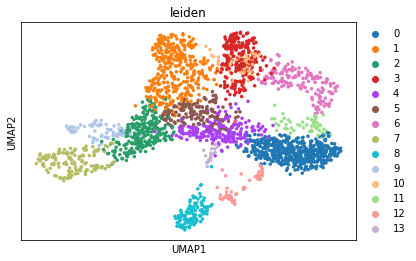

In [3]:
sc.pl.umap(adata_A, color=['leiden'])

In [5]:
adata_A.obs['x'] = adata_A.obsm['spatial'].T[0]
adata_A.obs['y'] = adata_A.obsm['spatial'].T[1]

In [72]:
from scipy.signal import convolve
from scipy.signal import convolve2d
from scipy.sparse import csr_matrix
from tqdm import tqdm

def get_3D_matrix(adata):
    x_max = int(adata.obs['x'].max())
    y_max = int(adata.obs['y'].max())
    # the spatial coordinates should be in adata.obs
    threeD_array = np.zeros((int(x_max), int(y_max), int(adata.var.shape[0])))
    print('Transfer anndate to 3D matrix...')
    for spot in tqdm(adata, bar_format='{l_bar}{bar:20}{r_bar}{percentage:3.0f}%'):
        x = int(spot.obs['x'])-1
        y = int(spot.obs['y'])-1
        threeD_array[x, y] = spot.X.toarray()
    return threeD_array


def convolve(array):
    kernel_A = np.array([[-1, -1, -1, -1, -1],
                         [-1,  2,  2,  2, -1],
                         [-1,  2,  8,  2, -1],
                         [-1,  2,  2,  2, -1],
                         [-1, -1, -1, -1, -1]])

    kernel_B = np.array([[0, -1, 0],
                         [-1, 5, -1],
                         [0, -1, 0]])

    n, m, k = array.shape
    # convolve each 2D layer
    output_array = np.zeros((n, m, k))
    print('Convolve each 2D layer...')
    for i in tqdm(range(k), bar_format='{l_bar}{bar:20}{r_bar}{percentage:3.0f}%'):
        output_array[:, :, i] = convolve2d(array[:, :, i], kernel_A, mode='same')
    output_array = np.where(output_array < 0, 0, output_array)
    return output_array


def update_anndata(array, adata):
    print('Update anndata...')
    for spot in tqdm(adata, bar_format='{l_bar}{bar:20}{r_bar}{percentage:3.0f}%'):
        x = int(spot.obs['x'])-1
        y = int(spot.obs['y'])-1
        spot.X = csr_matrix(array[x, y])
    

In [69]:
result = convolve(get_3D_matrix(adata_A))

100%|████████████████████| 32268/32268 [01:31<00:00, 353.19it/s]100%


In [73]:
update_anndata(result, adata_A)

Update anndata...


 59%|███████████▊        | 1431/2425 [17:47<08:04,  2.05it/s] 59% f:\conda\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|████████████████████| 2425/2425 [28:06<00:00,  1.44it/s]100%


In [47]:
csr_matrix(result[1,1]).shape

(1, 32268)

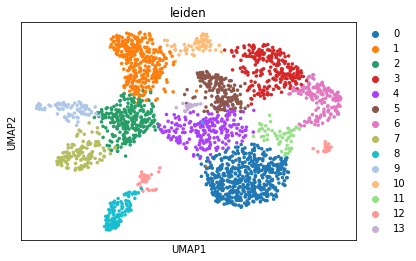

In [88]:
sc.tl.pca(adata_A, svd_solver='arpack')
sc.tl.umap(adata_A)
sc.tl.leiden(adata_A)
sc.pl.umap(adata_A, color=['leiden'])

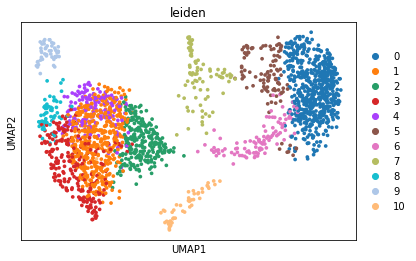

In [92]:
sc.pl.umap(adata_B, color=['leiden'])

In [94]:
adata_B.obs['x'] = adata_B.obsm['spatial'].T[0]
adata_B.obs['y'] = adata_B.obsm['spatial'].T[1]
result_B = convolve(get_3D_matrix(adata_B))
update_anndata(result_B, adata_B)

Transfer anndate to 3D matrix...


100%|████████████████████| 2179/2179 [00:16<00:00, 132.55it/s]100%


Convolve each 2D layer...


100%|████████████████████| 32268/32268 [01:04<00:00, 503.05it/s]100%


Update anndata...


 95%|███████████████████ | 2080/2179 [45:43<02:06,  1.28s/it] 95%f:\conda\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|████████████████████| 2179/2179 [48:10<00:00,  1.33s/it]100%


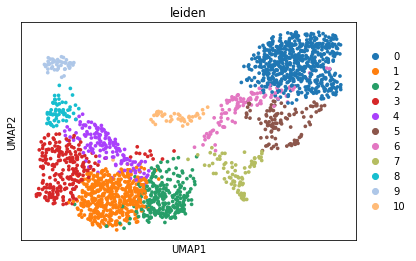

In [95]:
sc.tl.pca(adata_B, svd_solver='arpack')
sc.tl.umap(adata_B)
sc.tl.leiden(adata_B)
sc.pl.umap(adata_B, color=['leiden'])

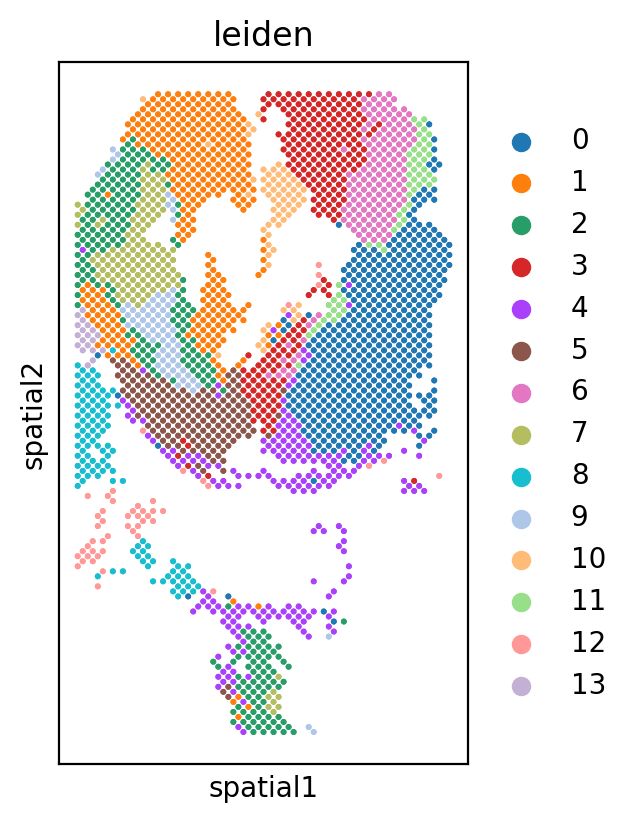

In [107]:
import squidpy as sq
sq.pl.spatial_scatter(adata_A, shape=None, color="leiden", size=5, dpi=200)

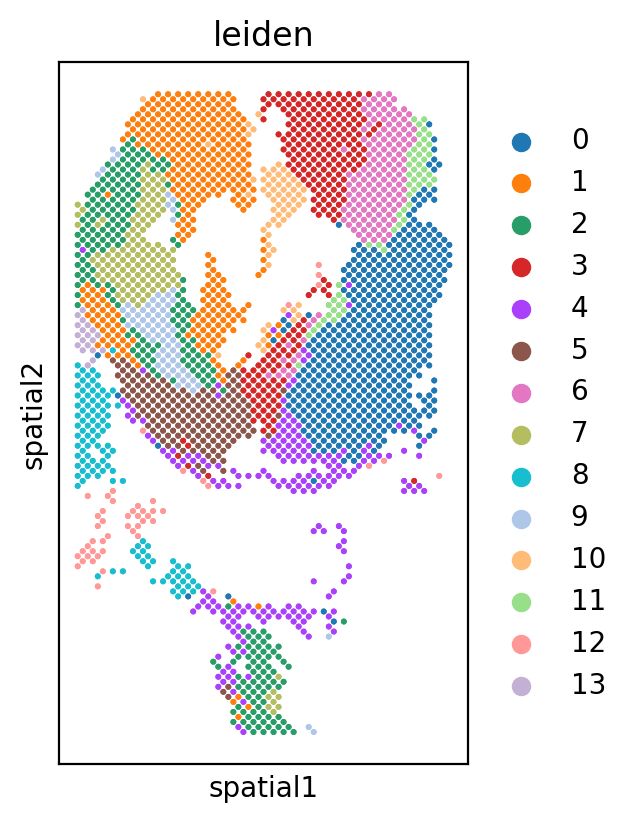

In [106]:
sq.pl.spatial_scatter(ctrl_A, shape=None, color="leiden", size=5, dpi=200)

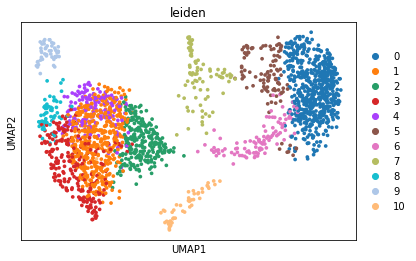

In [101]:
sc.pl.umap(ctrl, color=['leiden'])